In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from skimage.io import imread
from sklearn.utils import shuffle
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
import keras
import cv2

In [2]:
root_path = "./data/"
train_path = root_path + "train"
test_path = root_path + "test"

### prep

In [3]:
def read_data(directorio, reshape_dim=(32,32)):
    X = [] 
    y = []
    for folder in os.listdir(directorio):
        if os.path.isdir(os.path.join(directorio, folder)):
            for file in os.listdir(os.path.join(directorio, folder)):
                image_path = os.path.join(directorio, folder, file)
                image = cv2.imread(image_path)
                if image is not None:  # Verificar si la imagen se leyó correctamente
                    image = cv2.resize(image, reshape_dim) # Redimensionamos las imágenes a 32x32
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Convertimos de BGR a RGB

                    X.append(image)
                    y.append(folder)
                else:
                    print(f"Advertencia: No se pudo leer la imagen correctamente: {image_path}")
    return np.array(X), np.array(y)


In [4]:
X_test, y_test = read_data(test_path, reshape_dim=(128,128))

In [5]:
X_test.shape, y_test.shape

((80, 128, 128, 3), (80,))

In [6]:
X_train, y_train = read_data(train_path, reshape_dim=(128,128))

In [7]:
X_train.shape, y_train.shape

((291, 128, 128, 3), (291,))

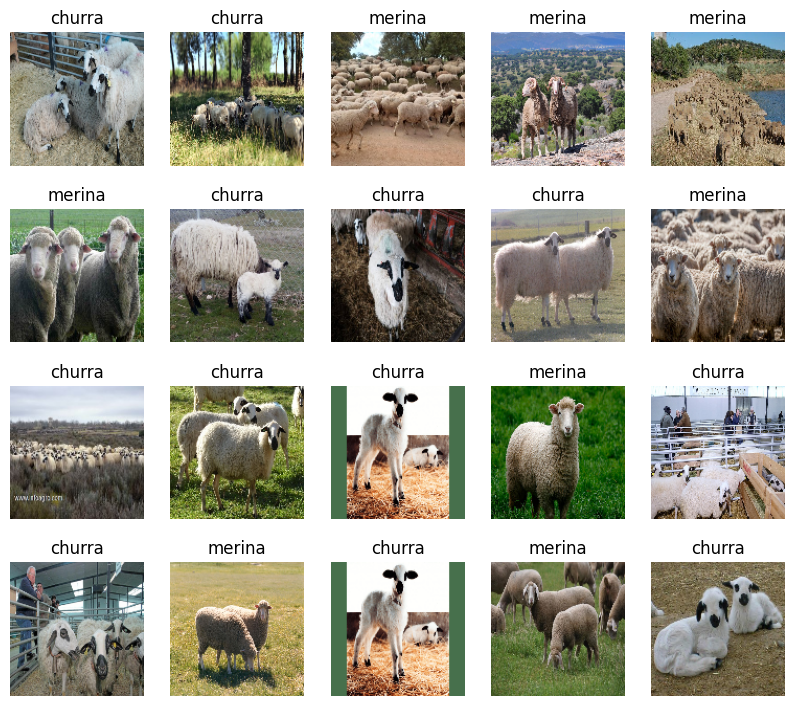

In [8]:
def show_images_batch(paisajes, names = [], n_cols = 5, size_scale = 2):
    n_rows = ((len(paisajes) - 1) // n_cols + 1)
    plt.figure(figsize=(n_cols * size_scale, n_rows * 1.1*size_scale))
    for index, paisaje in enumerate(paisajes):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(paisaje, cmap = "Greys")
        plt.axis("off")
        if len(names):
            plt.title(names[index])
            
indices = np.random.randint(0,len(X_train),20)
show_images_batch(X_train[indices], names = y_train[indices], n_cols = 5)

In [9]:
mapa = {"churra":0,
        "merina":1}
inverse_mapping = {0:"churra",
                   1:"merina"}

In [10]:
X_train = X_train / 255
X_test = X_test / 255

In [11]:
X_train, y_train = shuffle(X_train, y_train)
X_test, y_test = shuffle(X_test, y_test)

In [12]:
X_train.shape

(291, 128, 128, 3)

### baseline random forest

In [13]:
X_train.shape, X_test.shape

((291, 128, 128, 3), (80, 128, 128, 3))

In [14]:
X_train_rf = X_train.reshape(291,-1)
X_test_rf = X_test.reshape(80,-1)

In [15]:
X_train_rf.shape, X_test_rf.shape

((291, 49152), (80, 49152))

In [16]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()

rf.fit(X_train_rf, y_train)

y_pred_rf = rf.predict(X_test_rf)
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

      churra       0.55      0.60      0.57        40
      merina       0.56      0.50      0.53        40

    accuracy                           0.55        80
   macro avg       0.55      0.55      0.55        80
weighted avg       0.55      0.55      0.55        80



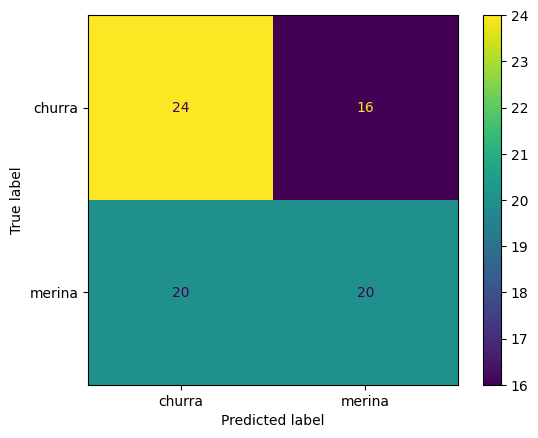

In [17]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf)

### convo

In [18]:
capas = [
    keras.layers.Input(shape=(128, 128, 3)),

    keras.layers.Conv2D(filters=30, kernel_size=(3, 3), padding="same", activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),

    keras.layers.Conv2D(filters=15, kernel_size=(3, 3), padding="same", activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),

    keras.layers.Flatten(),
    
    keras.layers.Dense(units=15360, activation='relu'), # resolucion aplanada
    keras.layers.Dense(units=1, activation='sigmoid')
]

model = keras.Sequential(capas)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 30)   │           840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 30)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 15)     │         4,065 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 15)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 15360)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 15360)          │   235,944,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │        15,361 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 235,965,226 (900.14 MB)

 Trainable params: 235,965,226 (900.14 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
y_train_num = np.array(pd.Series(y_train).map(mapa))
y_test_num = np.array(pd.Series(y_test).map(mapa))

In [20]:
history = model.fit(X_train,
                    y_train_num,
                    validation_split=.2,
                    epochs=50,
                    batch_size = 32,
                    callbacks=[keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)])

Epoch 1/50


8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.5080 - loss: 11.4218 - val_accuracy: 0.5254 - val_loss: 0.8898
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.5142 - loss: 0.8144 - val_accuracy: 0.5593 - val_loss: 0.6734
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.5963 - loss: 0.6530 - val_accuracy: 0.5932 - val_loss: 0.6669
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.7843 - loss: 0.6060 - val_accuracy: 0.6441 - val_loss: 0.6245
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.8438 - loss: 0.4628 - val_accuracy: 0.5932 - val_loss: 0.7338
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.7929 - loss: 0.3600 - val_accuracy: 0.5085 - val_loss: 0.8422
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.8701 - loss: 0.2990 - val_accuracy: 0.5763 - val_loss: 0.6696
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.9494 - loss: 0.1532 - val_accuracy: 0.6102 - val_loss: 0.9595
Epoch 9/50
8/8 ━━━

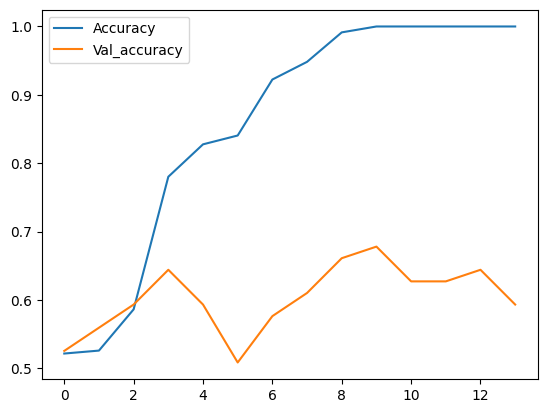

In [21]:
# Representamos el objeto history
history_df = pd.DataFrame(history.history)
plt.plot(history_df['accuracy'], label = 'Accuracy')
plt.plot(history_df['val_accuracy'], label = 'Val_accuracy')

plt.legend();

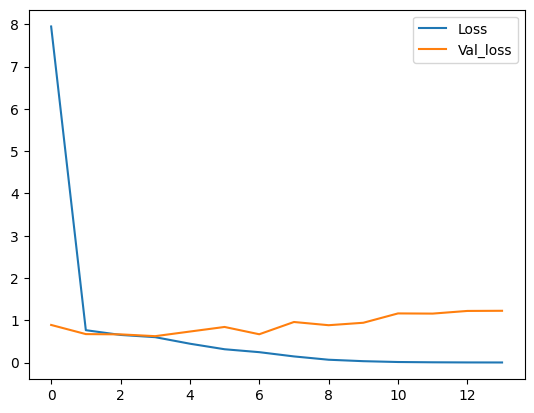

In [22]:
plt.plot(history_df['loss'], label = 'Loss')
plt.plot(history_df['val_loss'], label = 'Val_loss')

plt.legend();

In [23]:
model.evaluate(X_test, y_test_num)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.5227 - loss: 0.6977


[0.6730362772941589, 0.5375000238418579]

In [24]:
predictions = model.predict(X_test)
y_pred = (predictions > 0.5).astype(int)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


In [25]:
print(classification_report(y_test_num, y_pred))

              precision    recall  f1-score   support

           0       0.56      0.35      0.43        40
           1       0.53      0.72      0.61        40

    accuracy                           0.54        80
   macro avg       0.54      0.54      0.52        80
weighted avg       0.54      0.54      0.52        80



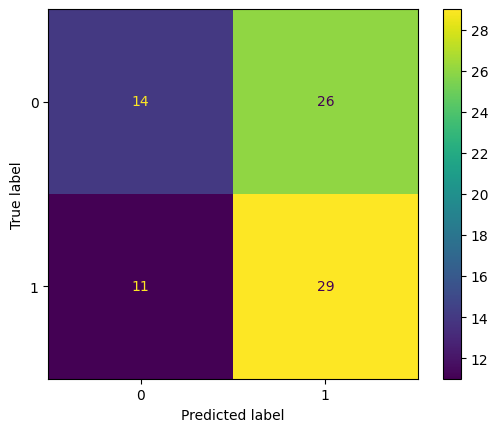

In [26]:
ConfusionMatrixDisplay.from_predictions(y_test_num, y_pred)

### image data generator

In [27]:
train_path = "./data/train"  # Suponiendo que este es tu directorio de entrenamiento
directorios = [train_path+"/churra", train_path+"/merina"]
ficheros = []
clases = []

for directorio in directorios:
    clase = directorio.split("/")[-1]  # Obtiene el nombre del directorio como la categoría
    ficheros += [directorio + "/" + fichero for fichero in os.listdir(directorio)]
    clases += [clase for _ in os.listdir(directorio)]

train_augmented = pd.DataFrame({"filename": ficheros, "category": clases})
train_augmented


,filename,category
0,./data/train/churra/0094117D-C6C6-52CF-FD09E61...,churra
1,./data/train/churra/022D5VP4_1.webp,churra
2,./data/train/churra/05-250523-HERMANAMIENTO-CH...,churra
3,./data/train/churra/1000_F_147225458_NevG6mfIE...,churra
4,./data/train/churra/1000_F_209537025_VHstcDS0m...,churra
...,...,...
286,./data/train/merina/trashumancia_madrid_14_01....,merina
287,./data/train/merina/trasterminancia-6.jpeg,merina
288,./data/train/merina/una-oveja-merina-de-pie-en...,merina
289,./data/train/merina/unnamed.jpg,merina


In [28]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

example_df = train_augmented.sample(n=1).reset_index(drop=True)

train_datagen = ImageDataGenerator(
    rotation_range=15, # Angulo de rotación
    rescale=1./255, # Escalado, ya nos escala las imágenes
    shear_range=0.1, # Inclina las imágenes, no es giro es inclinación como hacerlas "cursivas"
    zoom_range=0.2, # Zoom
    horizontal_flip=True, # giro horizontal o especular
    width_shift_range=0.1, # Desplazamiento horizontal de los pixeles
    height_shift_range=0.1 # Desplazamiento vertical de los píxeles
)


example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    x_col='filename',
    y_col='category',
    target_size=(128, 128),
)

Found 1 validated image filenames belonging to 1 classes.


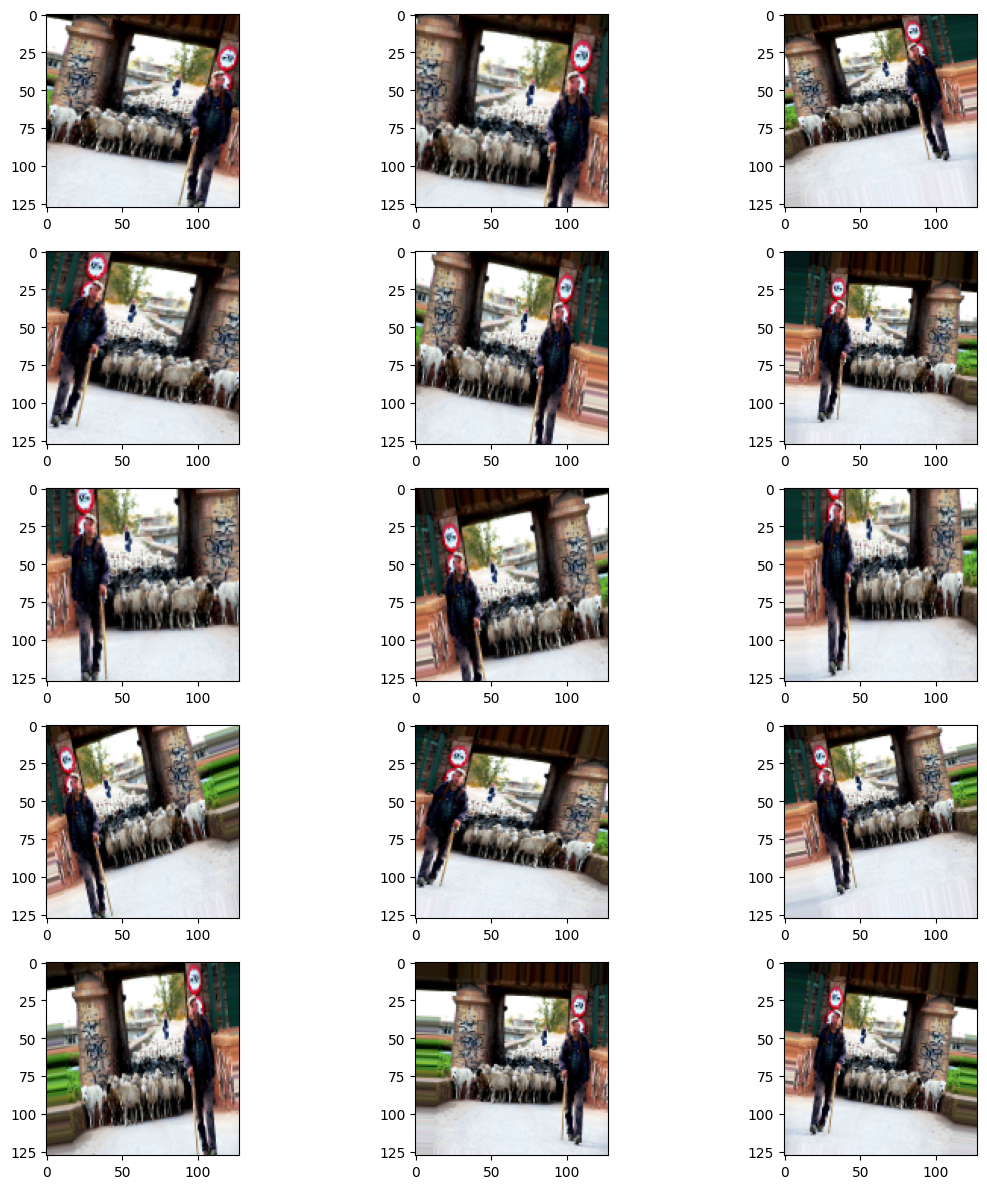

In [29]:
plt.figure(figsize=(12, 12))

for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [30]:
from sklearn.model_selection import train_test_split

train_df, validate_df = train_test_split(train_augmented,
                                         test_size=0.20,
                                         random_state=42)

In [31]:
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [32]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

print("Shape train", total_train)
print("Shape validation", total_validate)
validate_df.head()

Shape train 232
Shape validation 59


,filename,category
0,./data/train/churra/images (11).jpg,churra
1,./data/train/merina/merina_u.jpg,merina
2,./data/train/churra/ch 02_xoptimizadax--575x32...,churra
3,./data/train/merina/8_Foto.jpg,merina
4,./data/train/churra/razas-ovinas-4.webp,churra


In [33]:
train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    x_col='filename',
    y_col='category',
    target_size=(128, 128),
    class_mode='binary', # Porque es binaria, si fuera multiclase y en un sólo valor -> "sparse" (otras configuraciones, ver la documentación)
    batch_size= 32
)

Found 204 validated image filenames belonging to 2 classes.


c:\Users\Nur\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\legacy\preprocessing\image.py:920: UserWarning: Found 28 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


In [34]:
validation_datagen = ImageDataGenerator(rescale=1./255) # Solo vamos a reescalar
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    x_col='filename',
    y_col='category',
    target_size=(128, 128),
    class_mode='binary',
    batch_size= 32
)

Found 55 validated image filenames belonging to 2 classes.


c:\Users\Nur\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\legacy\preprocessing\image.py:920: UserWarning: Found 4 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


In [35]:
model = keras.Sequential(capas)

model.compile(optimizer="adam",
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [36]:
history = model.fit(
    train_generator, 
    epochs= 100,
    validation_data=validation_generator,
    callbacks= [keras.callbacks.EarlyStopping(patience=15,restore_best_weights=True)]
)

c:\Users\Nur\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/100


c:\Users\Nur\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 0.5471 - loss: 0.6886 - val_accuracy: 0.6727 - val_loss: 0.5848
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.5587 - loss: 0.7013 - val_accuracy: 0.6909 - val_loss: 0.6660
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.6248 - loss: 0.6773 - val_accuracy: 0.7091 - val_loss: 0.6672
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.5711 - loss: 0.6683 - val_accuracy: 0.6545 - val_loss: 0.6312
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.6102 - loss: 0.6394 - val_accuracy: 0.6182 - val_loss: 0.7499
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.6370 - loss: 0.5983 - val_accuracy: 0.6182 - val_loss: 0.6082
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.6202 - loss: 0.6200 - val_accuracy: 0.6727 - val_loss: 0.6518
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.6509 - loss: 0.6068 - val_accuracy: 0.7273 - val_loss: 0.6079
Epoch 9/100


In [37]:
results = model.evaluate(X_test, y_test_num)
print("test loss, test acc:", results)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.5461 - loss: 0.6825
test loss, test acc: [0.7081417441368103, 0.5375000238418579]


In [43]:
predictions = model.predict(X_test)
y_pred = (predictions > 0.5).astype(int)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


In [44]:
y_pred

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0]])

In [45]:
print(classification_report(y_test_num, y_pred))

              precision    recall  f1-score   support

           0       0.53      0.70      0.60        40
           1       0.56      0.38      0.45        40

    accuracy                           0.54        80
   macro avg       0.54      0.54      0.52        80
weighted avg       0.54      0.54      0.52        80



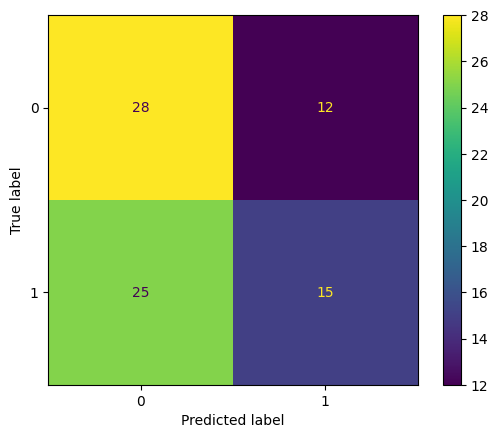

In [46]:
ConfusionMatrixDisplay.from_predictions(y_test_num,y_pred)

### transfer learning

In [32]:
from keras.applications import MobileNetV2
from keras import layers, Model

base_model = MobileNetV2(include_top=False, weights="imagenet", input_shape=(128,128,3))

for layer in base_model.layers:
    layer.trainable = False

def prepare_model(base_model=base_model):
    x = layers.Flatten()(base_model.output)

    x = layers.Dense(32, activation="relu")(x)
    x = layers.Dropout(rate=.50)(x)

    x = layers.Dense((pd.Series(y_train).nunique()), activation="softmax")(x)

    model = Model(base_model.input,x)

    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["acc"])
    
    return model

model = prepare_model()
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,913,442 (11.11 MB)

 Trainable params: 655,458 (2.50 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [33]:
early_stopping = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [34]:
model = prepare_model()
history = model.fit(X_train, y_train_num,
                    batch_size = 16,
                    validation_split = .2,
                    epochs = 100,
                    callbacks = [early_stopping])

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 190ms/step - acc: 0.5432 - loss: 1.5855 - val_acc: 0.7119 - val_loss: 0.5867
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - acc: 0.7411 - loss: 0.5388 - val_acc: 0.8136 - val_loss: 0.5476
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - acc: 0.8112 - loss: 0.3648 - val_acc: 0.8136 - val_loss: 0.5747
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - acc: 0.8549 - loss: 0.3252 - val_acc: 0.7966 - val_loss: 0.3884
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - acc: 0.9215 - loss: 0.2138 - val_acc: 0.8475 - val_loss: 0.3743
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - acc: 0.9234 - loss: 0.1682 - val_acc: 0.8814 - val_loss: 0.3284
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - acc: 0.9133 - loss: 0.1834 - val_acc: 0.8814 - val_loss: 0.3731
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - acc: 0.8899 - loss: 0.2223 - val_acc: 0.9153 - val_loss: 0.3237
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step 

In [35]:
model.evaluate(X_test, y_test_num)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - acc: 0.9359 - loss: 0.1506


[0.10517612844705582, 0.949999988079071]

In [36]:
y_pred = [inverse_mapping[np.argmax(prediccion)] for prediccion in model.predict(X_test)]
print(classification_report(y_test, y_pred))

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 763ms/step
              precision    recall  f1-score   support

      churra       0.97      0.93      0.95        40
      merina       0.93      0.97      0.95        40

    accuracy                           0.95        80
   macro avg       0.95      0.95      0.95        80
weighted avg       0.95      0.95      0.95        80



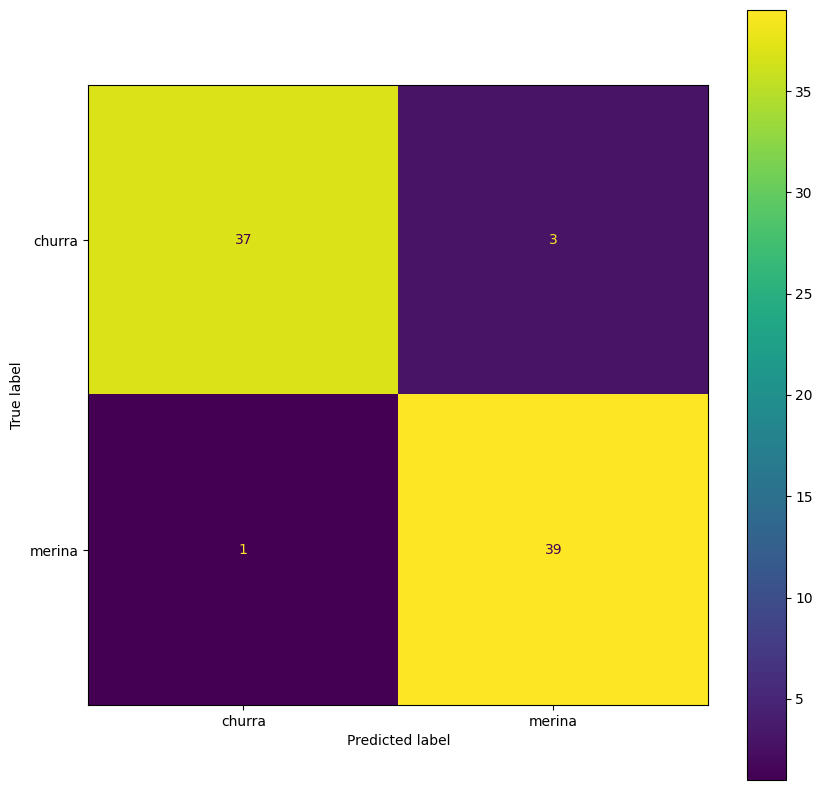

In [37]:
fig,axs = plt.subplots(1,1,figsize = (10,10))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax = axs)

In [38]:
128*128

16384

### otro transfer learning


In [39]:
from keras.applications import MobileNetV2
from keras import layers, Model

base_model = MobileNetV2(include_top=False, weights="imagenet", input_shape=(128,128,3))

for layer in base_model.layers:
    layer.trainable = False

def prepare_model(base_model=base_model):
    x = layers.Flatten()(base_model.output)

    x = layers.Dense(16384, activation="relu")(x)
    x = layers.Dropout(rate=.50)(x)

    x = layers.Dense(2, activation="softmax")(x)

    model = Model(base_model.input,x)

    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["acc"])
    
    return model

model = prepare_model()
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 337,851,458 (1.26 GB)

 Trainable params: 335,593,474 (1.25 GB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [41]:
model = prepare_model()
history = model.fit(X_train, y_train_num,
                    batch_size = 32,
                    validation_split = .2,
                    epochs = 100,
                    callbacks = [early_stopping])

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 63s 7s/step - acc: 0.5518 - loss: 44.8580 - val_acc: 0.9153 - val_loss: 6.5143
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - acc: 0.9324 - loss: 2.9017 - val_acc: 0.8644 - val_loss: 8.8879
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - acc: 0.9483 - loss: 1.5298 - val_acc: 0.8814 - val_loss: 6.9662
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - acc: 0.9580 - loss: 0.8860 - val_acc: 0.8136 - val_loss: 8.0140
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - acc: 1.0000 - loss: 4.4791e-05 - val_acc: 0.8475 - val_loss: 7.3621
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - acc: 0.9950 - loss: 0.0997 - val_acc: 0.8983 - val_loss: 6.1739
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - acc: 0.9985 - loss: 0.0064 - val_acc: 0.8983 - val_loss: 5.4724
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - acc: 1.0000 - loss: 0.0000e+00 - val_acc: 0.8983 - val_loss: 5.7702
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - acc: 1.0000 - loss: 

In [42]:
model.evaluate(X_test,y_test_num)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 236ms/step - acc: 0.9180 - loss: 3.2103


[2.1942138671875, 0.9375]

### fine tuning

In [43]:

base_model = MobileNetV2(include_top=False, weights=None, input_shape=(128,128,3))

for layer in base_model.layers:
    layer.trainable = False

def prepare_model(base_model=base_model):
    x = layers.Flatten()(base_model.output)

    x = layers.Dense(16384, activation="relu")(x)
    x = layers.Dropout(rate=.50)(x)

    x = layers.Dense(2, activation="softmax")(x)

    model = Model(base_model.input,x)

    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["acc"])
    
    return model

model = prepare_model()
model.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 337,851,458 (1.26 GB)

 Trainable params: 335,593,474 (1.25 GB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [44]:
model = prepare_model()
history = model.fit(X_train, 
                    y_train_num,
                    batch_size = 32,
                    validation_split=0.2,
                    epochs=40,
                    callbacks = [early_stopping])

Epoch 1/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 46s 4s/step - acc: 0.4304 - loss: 0.6951 - val_acc: 0.4576 - val_loss: 0.6937
Epoch 2/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - acc: 0.5173 - loss: 0.6937 - val_acc: 0.4576 - val_loss: 0.6995
Epoch 3/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - acc: 0.5392 - loss: 0.6907 - val_acc: 0.4576 - val_loss: 0.6983
Epoch 4/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - acc: 0.5312 - loss: 0.6912 - val_acc: 0.4576 - val_loss: 0.6958
Epoch 5/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - acc: 0.4896 - loss: 0.6938 - val_acc: 0.5424 - val_loss: 0.6930
Epoch 6/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - acc: 0.4576 - loss: 0.6940 - val_acc: 0.4576 - val_loss: 0.6965
Epoch 7/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - acc: 0.5100 - loss: 0.6931 - val_acc: 0.4576 - val_loss: 0.6957
Epoch 8/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - acc: 0.5642 - loss: 0.6906 - val_acc: 0.4576 - val_loss: 0.6962
Epoch 9/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - acc: 0.4959 - loss: 0.6949 - val_acc: 